# Random Data as Input
Having a range of data, given the limits of position and velocity, generate uniform random data using the made up library of functions

In [1]:
import integrate_data as intd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# import torch

In [2]:
#input of global program (data about our network)
N_layers = 50
dt = 5e-2
name = "exp_random_data"
relative_tolerance = 1e-3

#comparission for post processing
xreal, epsilon = 10.0, 5e-1

# function for the differential equation
alpha = 1
def force_function(x):
    # return - alpha * x * x
    return (1/8000)*((x-1) * (x-11)**2 * (x-23)**2) - 0.7
    

In [3]:
# ========== input specific to random generation progam ==========
xlow, xhigh = -10.0, 20.0
vlow, vhigh = -5.0, 5.0
N_samples = 1000

In [4]:
# ===== inner definitions of the program ==================
xlimits = [xlow, xhigh]
vlimits = [vlow, vhigh]
# the first tuple is low limits for both
limits = list(zip(xlimits, vlimits))

# where we save the data information
global_data = []

#starting the generation of random data
random_xv = np.random.uniform(low=limits[0], high=limits[1], 
    size=(N_samples,2))

# defining the function for simulation
def f_dottz(t, z):
    """function in the differential equation"""
    x, v = z
    dzdt = [v, force_function(x)]
    return dzdt


In [5]:
# ====== Generation of data ================
for k_data in range(N_samples):
    # generate the series with the inputs
    xi = random_xv[k_data][0]
    vi = random_xv[k_data][1]

    arguments = intd.make_integrator_args(name,xi,vi,N_layers, dt)

    try:
        data_id, sol_estatus, data_generated = intd.run_integrator(
            arguments, vec_function=f_dottz, relative_tolerance=relative_tolerance)
        # we use the last data point
        data_point = [xi,vi,data_generated[-1][1], data_generated[-1][2] ]

    except ValueError:
        data_point = [xi, vi, np.nan, np.nan]

    global_data.append(data_point)

In [6]:
# creating global data for saving
total_data_frame = pd.DataFrame(global_data, columns=["xi", "vi", "xf", "vf"])
total_data_frame.head()

,xi,vi,xf,vf
0,-2.783524,4.368099,NaN,NaN
1,13.561415,-1.160312,9.978919,-2.131979
2,14.270668,-0.802627,13.487787,-0.020286
3,12.335550,2.268233,19.644471,4.726475
4,12.564546,-4.028556,5.109839,1.138376


now to this data frame we add a column that checks 3 possible conditions:
- `K=0` if `xf` close to `xreal` given `epsilon`
- `K=-1` if `xf` is `NaN`
- `K=1` any other case


In [7]:
epsilon = 2
# apply K
total_data_frame["K"] = total_data_frame.apply(
    lambda row: 0 if abs(row["xf"] - xreal) <= epsilon else 
                -1 if np.isnan(row["xf"]) else 1,
    axis=1
)

# data in the range where xf is close to xreal (normally set to 0)
print(f"Total positive data K=0: {sum(total_data_frame['K'] == 0)} data points")


Total positive data K=0: 153 data points


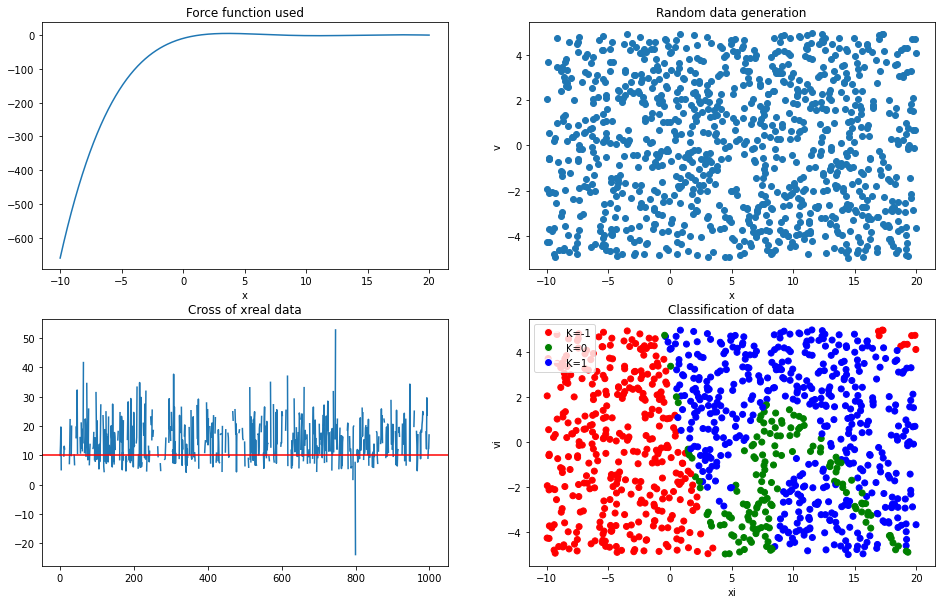

In [8]:
### all plots together

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16,10))

ax[0][0].set_title("Force function used")
x_plot = np.linspace(xlow, xhigh, 400)
ax[0][0].plot(x_plot, force_function(x_plot))
ax[0][0].set_xlabel('x')

ax[0][1].set_title("Random data generation")
ax[0][1].scatter(random_xv[:,0], random_xv[:,1])
ax[0][1].set_xlabel('x')
ax[0][1].set_ylabel('v')

ax[1][0].set_title("Cross of xreal data")
ax[1][0].plot(total_data_frame.xf)
ax[1][0].axhline(y=xreal, color='r', linestyle='-')


ax[1][1].set_title("Classification of data")
colors = {-1: 'red', 0: 'green', 1: 'blue'}
labels = {-1: 'K=-1', 0: 'K=0', 1: 'K=1'}
ax[1][1].scatter(total_data_frame['xi'], total_data_frame['vi'], 
    c=total_data_frame['K'].apply(lambda x: colors[x]),
    label=total_data_frame['K'].apply(lambda x: labels[x]))
ax[1][1].set_xlabel('xi')
ax[1][1].set_ylabel('vi')
legend_elements = [(labels[x], colors[x]) for x in total_data_frame['K'].unique()]
ax[1][1].legend(handles=[plt.Line2D([], [], marker='o', color='w', label=label, markerfacecolor=color, markersize=8) for label, color in legend_elements], loc='best')



plt.show()

### Maping as 3D distance -> K continuous


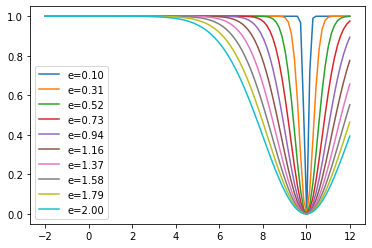

In [9]:
def narrow_gaussian(x, mu=0, sigma=0.01):
    pdf = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-(x - mu)**2 / (2 * sigma**2))
    return 1-pdf / pdf.max()

x = np.linspace(-2,2+xreal,100)
for epsilon_plot in np.linspace(0.1, 2, 10):
    plt.plot(x, narrow_gaussian(x, mu=xreal, 
        sigma=epsilon_plot), label=f"e={epsilon_plot :.2f}")
plt.legend(loc='lower left')

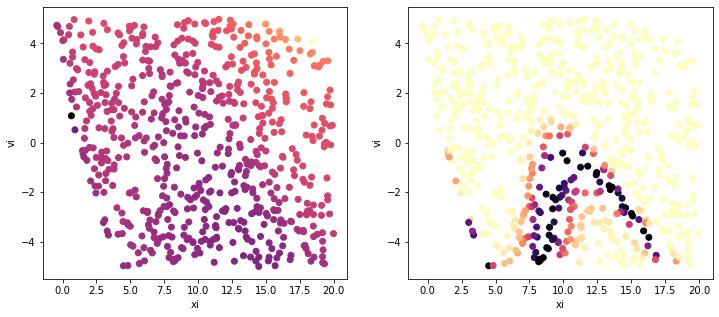

In [40]:
xreal = 8

total_data_frame['c_K'] = narrow_gaussian(
    total_data_frame['xf'],mu=xreal, sigma=0.94)
# total_data_frame['c_K'] = total_data_frame['c_K'].fillna(-1)
# total_data_frame[['xf', 'K', 'c_K']]


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ax[0].scatter(total_data_frame['xi'], 
    total_data_frame['vi'], c=total_data_frame['xf'], cmap="magma")
ax[0].set_xlabel('xi')
ax[0].set_ylabel('vi')

ax[1].scatter(total_data_frame['xi'],
    total_data_frame['vi'], c=total_data_frame['c_K'][:len(total_data_frame['xi'])], cmap="magma")
ax[1].set_xlabel('xi')
ax[1].set_ylabel('vi')

plt.show()

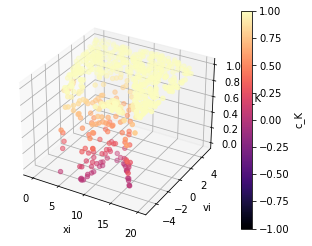

In [41]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.colors as colors


cmap = 'magma'
#cmap = colors.ListedColormap(['red', 'green', 'blue'])
norm = colors.Normalize(vmin=-1, vmax=1)


# define colors for each value of c_K
# colors = {-1: 'red', 0: 'green', 1: 'blue'}

# create a 3D scatter plot with xi, vi, and c_K as x, y, and z axes, and color the points according to c_K
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(total_data_frame['xi'], total_data_frame['vi'], 
    total_data_frame['c_K'], c=total_data_frame['c_K'], cmap=cmap, norm=norm)

# add axis labels
ax.set_xlabel('xi')
ax.set_ylabel('vi')
ax.set_zlabel('c_K')

# add a colorbar to show the color gradient
cbar = plt.colorbar(ax.collections[0])
cbar.set_label('c_K')
plt.show()